# Load libraries and Data

In [1]:
from pyhive import presto

def get_presto_conn():
    # need to impersonate to the owner to drop exisiting tables
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086, username='wandajuan')

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# MP mWeb best seller labels v2

In [50]:
# latest ramp period
start_date = '2022-05-18'
end_date = '2022-05-24'
test_name = 'mp_mweb_best_seller_label_v2'
control = 'control'
treatment = 'treatment'
# device_cat = "('Personal computer')" 
device_cat = "('Tablet','Smartphone')"
tmp_visitor_base = 'wandajuan.visitor_base_' + test_name
tmp_mp_metrics = 'wandajuan.mp_metrics_' + test_name
tmp_xo_metrics = 'wandajuan.xo_metrics_' + test_name
tmp_browse_ranking = 'wandajuan.browse_ranking_' + test_name
tmp_final_table = 'wandajuan.' + test_name

## User Base

In [7]:
# Test user base:

q = """DROP TABLE IF EXISTS {tmp_visitor_base}""".format(tmp_visitor_base=tmp_visitor_base)
print(pd.read_sql(q, conn))

print('run query below in presto:')


q = """
CREATE TABLE {tmp_visitor_base} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and visitor_id in (
                        select distinct visitor_id
                            from l2.session_analytics core 
                        WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
                          and CAST(country as varchar) in ('US') 
                          and CAST(site_id as varchar) in ('101') 
                          AND device_cat != '' 
                          AND (test_set like '%{test_name}=%') 
                          and device_cat in {device_cat}
                          and session_id not in (
                                            select session_id 
                                            from l2.session_summary 
                                            where user_agent like '%test_automation%' 
                                            and dt>= '{start_date}') 
                      )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_visitor_base=tmp_visitor_base,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

# print(q)
pd.read_sql(q, conn)

   result
0    True
run query below in presto:


,rows
0,53507


In [8]:
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_visitor_base} group by 1 order by 1""".format(tmp_visitor_base=tmp_visitor_base),conn)

,test_variant,_col1
0,control,26965
1,treatment_b,26542


with or without dedup, total # visitors in manual pull is more than abdash, which is 1155, 1131

In [9]:
test_users = pd.read_sql('select * from {tmp_visitor_base}'.format(tmp_visitor_base=tmp_visitor_base), conn)
test_users

,visitor_id,test_variant,dt
0,d60e67bb-cc7b-45d3-875f-d40569c8ae91,control,2022-05-19
1,edb0c0f7-c95d-4d3e-be6f-3ea7542896de,control,2022-05-18
2,52a092ae-88d5-4d0a-9cb0-64d1ef2cfb35,control,2022-05-23
3,4ebc659f-1f6c-49fd-907d-a90f96c05da1,control,2022-05-22
4,53dbc0e2-852f-4a71-8162-2b3872a25e71,control,2022-05-19
...,...,...,...
53502,c51a62e2-c29b-45a0-b92b-036236c1e899,treatment_b,2022-05-24
53503,404478f8-1448-4ca1-aa94-be152e7435c8,control,2022-05-21
53504,bb7bf235-cfe4-4afb-9acb-35b503b8eef5,treatment_b,2022-05-21
53505,a573644d-8ffc-4fb9-83a7-13dc2caa9590,control,2022-05-21


## MP table

In [11]:
# MP Metrics: since there are not that many rows - 2K+ -> pull the entire pos
print(pd.read_sql('drop table if exists {tmp_mp_metrics}'.format(tmp_mp_metrics=tmp_mp_metrics), conn))


print('run query below in presto:')

q = """
CREATE TABLE {tmp_mp_metrics} AS

select 
		t0.*,
		t2.order_date, 
		t2.order_id,
		t2.created,
		t2.status,
		t2.item_id, 
		t2.house_id,
		if(bs.bs_rank is null, 0, 1) if_bs, 
		t2.item_gmv,
		t2.init_item_commission,
		t2.gmv_net_of_returns,
		t2.net_commission,
		t2.placed_order_item_coupon_amount,
		t2.is_trade_program,
		t2.session_id,
		t2.medium,
		t2.l1_category,
		t2.browser,
		t2.os,
		t2.device_cat,
		t2.channel,
		t2.new_visitor,
		t2.landing_page_class,
		
		( case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
		( case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
		( case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
		( case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
		( case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
		( case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
		( case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
		( case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv
from {tmp_visitor_base} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
left join shop.product_best_seller_rank_monthly bs
	on t2.house_id = bs.house_id  and bs.mt = '2022-04'
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0
  -- not excluding trade orders 
--  and is_trade_program = 0
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_mp_metrics = tmp_mp_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

   result
0    True
run query below in presto:


,rows
0,1063


In [17]:
mp = pd.read_sql("select * from {tmp_mp_metrics}".format(tmp_mp_metrics=tmp_mp_metrics), conn)
mp

,visitor_id,test_variant,dt,order_date,order_id,created,status,item_id,house_id,if_bs,item_gmv,init_item_commission,gmv_net_of_returns,net_commission,placed_order_item_coupon_amount,is_trade_program,session_id,medium,l1_category,browser,os,device_cat,channel,new_visitor,landing_page_class,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,d33d2801-07d7-4156-b91b-0acbbc12067c,treatment_b,2022-05-21,2022-05-21,1733441801954962,2022-05-21 06:15:25.0,4,113550598,159142155,1,141.00,44.664286,141.00,44.664286,0.0,0,62d825248d5529559b34686b7996b2e9,PAID,products->lighting,Mobile Safari,iOS,Smartphone,paid,True,pvp,1.733442e+15,NaN,NaN,None,NaN,1.733442e+15,NaN,None,NaN,141.00
1,20b44e59-8068-47e0-a859-d36211b36232,control,2022-05-19,2022-05-24,1733750395164754,2022-05-24 16:00:22.0,3,117454577,81428094,0,45.00,8.810000,45.00,8.810000,0.0,0,3c07df167c3b7e8c0f1ee31c3b951b5c,PAID,products->storage and organization,Chrome Mobile,iOS,Smartphone,paid,False,VIEW_CART,1.733750e+15,NaN,1.733750e+15,None,NaN,NaN,45.0,None,NaN,NaN
2,20b44e59-8068-47e0-a859-d36211b36232,control,2022-05-19,2022-05-24,1733750395164754,2022-05-24 16:00:22.0,3,117454577,81428094,0,45.00,8.810000,45.00,8.810000,0.0,0,3c07df167c3b7e8c0f1ee31c3b951b5c,PAID,products->storage and organization,Chrome Mobile,iOS,Smartphone,paid,False,VIEW_CART,1.733750e+15,NaN,1.733750e+15,None,NaN,NaN,45.0,None,NaN,NaN
3,b0ff7d14-02fe-4010-933e-32d132ad3d2f,control,2022-05-21,2022-05-24,1733726272608319,2022-05-24 09:36:57.0,3,14174323,14609675,0,42.94,7.729200,42.94,7.730000,0.0,0,679e10dee815f6f68339a102ca07c176,DIRECT,products->home decor,Mobile Safari,iOS,Smartphone,direct,False,VIEW_CART,NaN,1.733726e+15,NaN,None,NaN,1.733726e+15,NaN,None,NaN,42.94
4,b0ff7d14-02fe-4010-933e-32d132ad3d2f,control,2022-05-21,2022-05-24,1733726272608319,2022-05-24 09:36:57.0,3,14174323,14609675,0,42.94,7.729200,42.94,7.730000,0.0,0,679e10dee815f6f68339a102ca07c176,DIRECT,products->home decor,Mobile Safari,iOS,Smartphone,direct,False,VIEW_CART,NaN,1.733726e+15,NaN,None,NaN,1.733726e+15,NaN,None,NaN,42.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,6f051778-a47f-43c5-8b3f-c4cd238e52c4,control,2022-05-22,2022-05-22,1733587993670203,2022-05-22 20:59:04.0,3,124708561,181835607,0,294.29,52.972200,294.29,52.970000,0.0,0,76882eef2292ae300c26d253aa8040aa,DIRECT,products->furniture,Mobile Safari,iOS,Smartphone,direct,False,VIEW_PRODUCT,1.733588e+15,NaN,NaN,None,NaN,1.733588e+15,NaN,None,NaN,294.29
1059,6c0df6bd-b1b8-486b-94ee-76d6dea5e0cb,treatment_b,2022-05-18,2022-05-18,1733222741595808,2022-05-18 20:13:33.0,4,121004967,176058909,0,3.50,0.630000,3.50,0.630000,0.0,0,e93745986d3eb36368430c11a50b0c8f,DIRECT,products->home improvement,Mobile Safari,iOS,Smartphone,direct,False,VIEW_CART,NaN,1.733223e+15,NaN,None,NaN,1.733223e+15,NaN,None,NaN,3.50
1060,4d884d01-6c55-4419-a1b2-26e125732cbb,treatment_b,2022-05-20,2022-05-21,1733435576826504,2022-05-21 04:36:28.0,4,82575451,108783852,0,56.00,15.440000,56.00,15.440000,0.0,0,641c24a96f7979be47bb2128ed30600e,PAID,products->tabletop,Mobile Safari,iOS,Smartphone,paid,False,pvp,1.733436e+15,NaN,NaN,None,NaN,1.733436e+15,NaN,None,NaN,56.00
1061,77fe0f56-33cf-494a-8e8c-cb1cfd423dd3,treatment_b,2022-05-18,2022-05-19,1733306871815472,2022-05-19 18:30:46.0,4,96506194,127824020,0,358.00,113.132500,358.00,113.132500,0.0,0,83c52b65b91818f47746de7cdbccde9c,PAID,products->lighting,Chrome Mobile,Android,Smartphone,paid,False,browseOrders,NaN,1.733307e+15,1.733307e+15,None,NaN,NaN,358.0,None,NaN,NaN


## XO Table

In [13]:
# Checkout Metrics:

pd.read_sql('drop table if exists {tmp_xo_metrics}'.format(tmp_xo_metrics=tmp_xo_metrics), conn)


print('run query below in presto:')

q = """
CREATE TABLE {tmp_xo_metrics} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*
from {tmp_visitor_base} t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_xo_metrics = tmp_xo_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,80103


In [23]:
xo = pd.read_sql("select * from {tmp_xo_metrics}".format(tmp_xo_metrics = tmp_xo_metrics), conn)
xo

test_variant  trigger_dt                        session_id  \
0          control  2022-05-20  4d55a173cc4a646dd4af4eaca594cf38   
1          control  2022-05-20  f245556c074169e0661a271b6f8d4aa2   
2          control  2022-05-20  98201d9e4cdb4e74469596837dd77347   
3          control  2022-05-20  e0a65b7e2c0bb06a40fd68cb340bfd85   
4          control  2022-05-20  90e86f9360d2cc8a87f2df7494c41fde   
...            ...         ...                               ...   
80098      control  2022-05-19  96d236f409a1929f2614baea1800ce6d   
80099      control  2022-05-18  6a3a604a96dbc280de6e8e5a332f42dc   
80100  treatment_b  2022-05-18  7009cf785748dbe38d3c307281116969   
80101      control  2022-05-20   d72b73c08e3f9804d2d5406cedef580   
80102  treatment_b  2022-05-20  32dad2fc679ca0172e6cdb620f5c6984   

                                 visitor_id  user_id  nl_id  nl_user_id  \
0      679e9f15-c321-4e17-bdfa-1b9cb8110c96      NaN      0           0   
1      83847d5d-dca9-4342-914a-42f996651532      NaN      0           0   
2      83847d5d-dca9-4342-914a-42f996651532      NaN      0           0   
3      83847d5d-dca9-4342-914a-42f996651532      NaN      0           0   
4      83847d5d-dca9-4342-914a-42f996651532      NaN      0           0   
...                                     ...      ...    ...         ...   
80098  cb230e3c-30a9-4acd-9204-4cba27011cf8      NaN      0           0   
80099  3491d201-fb4a-43a9-8e33-fb7597b60bb2      NaN      0           0   
80100  e40699e0-5385-4750-846d-e8ca5003a980      NaN      0           0   
80101  ac99a8e6-7333-45ca-8492-a5ac616e2b35      NaN      0           0   
80102  b97fff88-99fd-44d3-9f8c-115f3f213385      NaN      0           0   

       site_id    start_ts      end_ts  \
0          101  1653099194  1653099251   
1          101  1653100098  1653100312   
2          101  1653100324  1653100470   
3          101  1653100480  1653101077   
4          101  1653099988  1653100062   
...        ...         ...         ...   
80098      101  1652996404  1652997771   
80099      101  1652913952  1652913955   
80100      101  1652913579  1652913585   
80101      101  1653087261  1653087264   
80102      101  1653064416  1653064549   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## daily browse to click conversion

In [15]:

# Checkout funnel with sign in status at the time of performing checkout actions:
print(pd.read_sql('drop table if exists {tmp_browse_ranking}'.format(tmp_browse_ranking=tmp_browse_ranking), conn))
se
print('run query below in presto:')

q = """
CREATE TABLE {tmp_browse_ranking} AS

select if(bs.bs_rank is null, 0, 1) if_bs, 
		v.test_variant, 
		p.search, pmi.*
from l2.page_views_daily p
join l2.page_modules_daily pm
	on p.page_key = pm.page_key and p.dt = pm.dt
join l2.page_module_items_daily pmi
	on pm.page_key = pm.page_key and pm.module_key = pmi.module_key and pm.dt = pmi.dt
left join shop.product_best_seller_rank_monthly bs
	on pmi.object_id = cast(bs.house_id as varchar) and bs.mt = '2022-04'
join {tmp_visitor_base} v
	on pmi.visitor_id = v.visitor_id and pmi.dt >= v.dt
where p.dt between '2022-05-18' and '2022-05-24'
and p.page_behavior =  'BROWSE_PRODUCTS' --and p.search != ''
and pm.module_type = 'BROWSE' 
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_browse_ranking = tmp_browse_ranking,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

   result
0    True
run query below in presto:


,rows
0,3927509


In [13]:
browse_ranking = pd.read_sql("select * from {tmp_browse_ranking}".format(tmp_browse_ranking=tmp_browse_ranking), conn)
browse_ranking

## Final Table

In [36]:
# Final Table:
pd.read_sql('drop table if exists {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)

print('run query below in presto:')

q = """
CREATE TABLE {tmp_final_table} AS

with xo as (

select dt, test_variant, visitor_id, 

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3

)
, mp as (

select order_date, test_variant, visitor_id,

	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv,
		
	-- bs mp metrics
		coalesce(count(distinct if(if_bs=1, order_id, null)),0) as bs_order_numbers,
    	count(if(if_bs=1, 1, null)) bs_units_sold,
	    sum(coalesce(if(if_bs=1, va.item_gmv, null),0)) as bs_order_gmv,
	    sum(coalesce(if(if_bs=1, va.item_gmv, null),0)+coalesce(if(if_bs=1, placed_order_item_coupon_amount, null), 0)) as bs_order_gmv_w_coupon,
	    sum(coalesce(if(if_bs=1, net_commission, null), 0)) as bs_net_commission,
	    sum(coalesce(if(if_bs=1, net_commission, null), 0)+coalesce(if(if_bs=1, placed_order_item_coupon_amount, null), 0)) as bs_net_commission_w_coupon,
    	coalesce(count(distinct if(if_bs=1, va.new_orders, null)),0) as bs_new_orders,
    	coalesce(count(distinct if(if_bs=1, va.old_orders, null)),0) as bs_old_orders,    
	    coalesce(count(distinct if(if_bs=1, cc_orders, null)), 0) as bs_cc_orders,
	    coalesce(count(distinct if(if_bs=1, apple_pay_orders, null)), 0) as bs_apple_pay_orders,
	    coalesce(count(distinct if(if_bs=1, afterpay_orders, null)), 0) as bs_afterpay_orders,
	    coalesce(count(distinct if(if_bs=1, paypal_orders, null)), 0) as bs_paypal_orders,
	    sum(coalesce(if(if_bs=1, cc_gmv, null), 0)) as bs_cc_gmv,
	    sum(coalesce(if(if_bs=1, apple_pay_gmv, null), 0)) as bs_apple_pay_gmv,
	    sum(coalesce(if(if_bs=1, afterpay_gmv, null), 0)) as bs_afterpay_gmv,
	    sum(coalesce(if(if_bs=1, paypal_gmv, null), 0)) as bs_paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3
)
select 
		coalesce(order_date, dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv, 

		bs_order_numbers,
		bs_units_sold,
		bs_order_gmv,
		bs_order_gmv_w_coupon,
		bs_net_commission,
		bs_net_commission_w_coupon,
		bs_new_orders,
		bs_old_orders,    
		bs_cc_orders,
		bs_apple_pay_orders,
		bs_afterpay_orders,
		bs_paypal_orders,
		bs_cc_gmv,
		bs_apple_pay_gmv,
		bs_afterpay_gmv,
		bs_paypal_gmv
from xo
full join mp
on xo.visitor_id = mp.visitor_id and xo.dt = mp.order_date
""".format(tmp_xo_metrics=tmp_xo_metrics,
           tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics,
            tmp_visitor_base=tmp_visitor_base,
            start_date=start_date,
            end_date=end_date)


# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,62678


In [37]:
df = pd.read_sql('select * from {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)
df

,dt,test_variant,visitor_id,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,2022-05-22,control,ecd15614-47e9-416a-9e34-59ca79cf1ad1,2,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-21,control,897ad8d1-eb5d-4d15-9e6b-9357f36e5146,32,11,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-21,treatment_b,de522e24-07e5-49c6-aa98-8c80d11e4570,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-23,control,bc698229-ba3d-4f5a-8e62-208a8f4ce521,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-23,control,3bebda58-4a1a-48af-af01-e56f2b838855,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62673,2022-05-24,control,0b0718c2-70e2-4915-84a8-a85313622cbf,1,2,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62674,2022-05-21,treatment_b,c458895f-6a96-4555-8566-dae44a2f6237,5,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62675,2022-05-21,treatment_b,efb9489e-c623-45f3-9e56-6ad2911869ca,4,4,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62676,2022-05-21,control,b5eebabc-79dc-4f29-8057-2b7b145f9b6d,1,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Helper functions

In [24]:
def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df
def color_negative_red(row):
    """ Color code lift or drop in test result dataframe if it is significant """
    return ['color: green' if row['Lift'] > 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else 'color: red' if row['Lift'] < 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else '' for v in row]

In [51]:
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment Size', 'Treatment Total', 'Treatment Mean',
               'Control Size', 'Control Total', 'Control Mean', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)]['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)]['visitors'].sum()
    total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric]
        trt = input_df[(input_df['test_variant'] == treatment)][metric]
        
        ctl_total = (input_df[(input_df['test_variant'] == control)][metric]*input_df[(input_df['test_variant'] == control)]['visitors']).sum()
        trt_total = (input_df[(input_df['test_variant'] == treatment)][metric]*input_df[(input_df['test_variant'] == treatment)]['visitors']).sum()
        
        row = [metric, trt_size, trt_total, trt.mean(), ctl_size, ctl_total, ctl.mean(), stats.ttest_ind(ctl, trt).pvalue]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 
                           'Control Total', 'Control Mean', 'Lift', 'Lift_%','P-value']]

# Analysis

## User distribution

In [38]:
df.groupby('test_variant')['visitor_id'].nunique()

test_variant
control        26965
treatment_b    26542
Name: visitor_id, dtype: int64

In [27]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique')

test_variant,control,treatment_b
dt,,
2022-05-18,4264,4100
2022-05-19,4836,4614
2022-05-20,4064,3991
2022-05-21,5257,5124
2022-05-22,4998,4847
2022-05-23,4392,4410
2022-05-24,3819,3962


<AxesSubplot:xlabel='dt'>

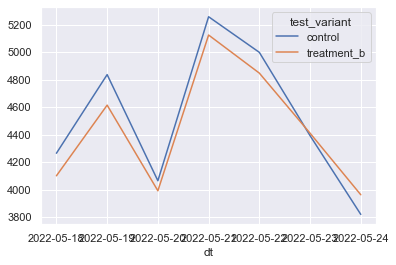

In [28]:
# number of users increased over the weekend
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique').plot()

## Remove outliers

In [29]:
# exclude qa
df = df.loc[~df['test_variant'].str.contains('qa')]

In [30]:
df[['dt', 'test_variant', 'visitor_id', 'order_gmv']].sort_values(by='order_gmv', ascending=False)

,dt,test_variant,visitor_id,order_gmv
9876,2022-05-19,treatment_b,77fe0f56-33cf-494a-8e8c-cb1cfd423dd3,8591.90
41441,2022-05-24,treatment_b,d8245d30-1971-44f2-9df2-854b43c1497e,5857.99
19904,2022-05-19,treatment_b,8d7c4da4-dea2-46a8-be2e-cde275e82cdc,4290.00
389,2022-05-21,treatment_b,58ee9247-cfb7-45b4-9cdb-e4de966dd943,4227.00
46686,2022-05-18,control,2fac83d4-a143-4957-b7a6-da693272f303,3671.88
...,...,...,...,...
62673,2022-05-20,control,af8c3bee-b91e-44b3-bc40-bbe04524fc5f,NaN
62674,2022-05-18,treatment_b,3b144f5a-d3ca-48e5-b642-202227cdba4e,NaN
62675,2022-05-21,control,849c6f06-a423-40e9-a357-a3ec30dd33a8,NaN
62676,2022-05-18,control,4b656337-87e8-4cd8-bc0b-0ca644a2062f,NaN


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='order_gmv', ylabel='Density'>

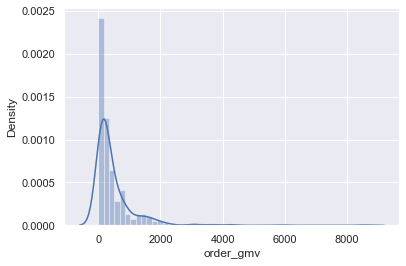

In [31]:
sns.distplot(df['order_gmv'])

<Figure size 1152x288 with 0 Axes>

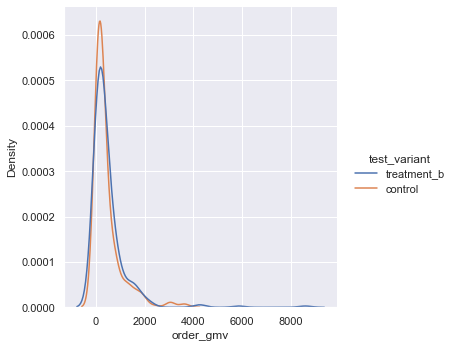

In [32]:
plt.figure(figsize=(16,4)) 
sns.displot(data=df, x='order_gmv', hue='test_variant', kind='kde')

<Figure size 1152x288 with 0 Axes>

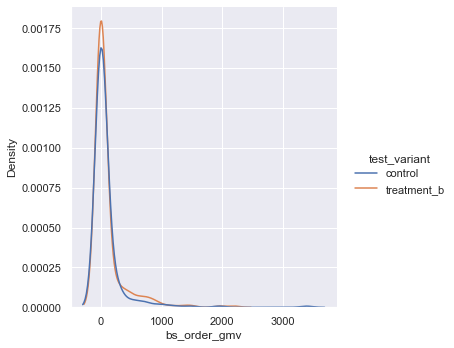

In [39]:
plt.figure(figsize=(16,4)) 
sns.displot(data=df, x='bs_order_gmv', hue='test_variant', kind='kde')

In [33]:
# for some reason, treatment seems to have more large gmv orders
df.loc[df['order_gmv']>3000]['test_variant'].value_counts()

control        5
treatment_b    4
Name: test_variant, dtype: int64

In [34]:
# excluding 0 large order from control
df = df.loc[df['order_gmv']<10000]

In [40]:
metrics = df.columns[3:]
# df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique())
dtd_metrics = df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique()).reset_index()
dtd_metrics

,dt,test_variant,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,2022-05-18,control,2.747889,1.446529,0.068011,0.055582,0.028612,0.030253,0.021107,0.022045,0.009615,0.013133,0.008208,0.013133,4.463295,4.438670,1.012399,0.987774,0.004221,0.003987,0.005394,0.0,0.000000,0.002814,2.998839,0.0,0.000000,1.464456,0.002580,0.004925,1.564545,1.564545,0.265820,0.265820,0.001407,0.001173,0.001407,0.0,0.0,0.001173,1.233994,0.0,0.0,0.330551
1,2022-05-18,treatment_b,2.536585,1.337561,0.062439,0.078780,0.027561,0.030732,0.018293,0.017561,0.010488,0.013659,0.016341,0.027561,4.269939,4.240671,1.013889,0.984620,0.008049,0.008293,0.012927,0.0,0.000000,0.003415,3.902207,0.0,0.000000,0.367732,0.003171,0.004878,0.471083,0.470271,0.115305,0.114493,0.001707,0.001463,0.002439,0.0,0.0,0.000732,0.382890,0.0,0.0,0.088193
2,2022-05-19,control,2.436311,1.403639,0.061414,0.054177,0.022953,0.026261,0.015922,0.011993,0.007237,0.012407,0.007444,0.010339,3.544615,3.544615,0.833386,0.833386,0.004756,0.002688,0.003929,0.0,0.000000,0.003515,1.823761,0.0,0.000000,1.720854,0.001241,0.002068,0.565341,0.565341,0.161708,0.161708,0.000827,0.000414,0.001241,0.0,0.0,0.000000,0.565341,0.0,0.0,0.000000
3,2022-05-19,treatment_b,2.467707,1.400520,0.073689,0.071305,0.030342,0.035977,0.023407,0.016472,0.011487,0.015388,0.013871,0.020373,6.453036,6.431363,1.531062,1.509389,0.007586,0.006285,0.012354,0.0,0.000000,0.001517,6.088476,0.0,0.000000,0.364560,0.003468,0.004985,1.634176,1.625507,0.460767,0.452097,0.002167,0.001300,0.003468,0.0,0.0,0.000000,1.634176,0.0,0.0,0.000000
4,2022-05-20,control,2.544783,1.418799,0.055856,0.058809,0.027313,0.029035,0.016486,0.017963,0.010581,0.012303,0.009843,0.012795,2.850381,2.840539,0.735066,0.725224,0.008612,0.001230,0.007136,0.0,0.000000,0.002707,2.568076,0.0,0.000000,0.282306,0.002215,0.003691,0.309001,0.309001,0.077921,0.077921,0.002215,0.000000,0.001476,0.0,0.0,0.000738,0.236907,0.0,0.0,0.072094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,2022-05-22,treatment_b,2.589643,1.466887,0.059831,0.059625,0.027233,0.030741,0.016505,0.013823,0.009078,0.013823,0.009697,0.013823,3.935490,3.918985,0.803572,0.787067,0.006189,0.003507,0.008046,0.0,0.000206,0.001444,3.603932,0.0,0.014852,0.316705,0.001857,0.003095,0.884875,0.876843,0.177032,0.169000,0.001238,0.000619,0.001444,0.0,0.0,0.000413,0.760056,0.0,0.0,0.124819
10,2022-05-23,control,2.451958,1.377732,0.059882,0.074909,0.027550,0.031421,0.017987,0.020264,0.009335,0.010929,0.008197,0.020492,3.375867,3.323500,0.863382,0.811014,0.004098,0.004098,0.005464,0.0,0.000455,0.002277,2.155467,0.0,0.034153,1.186248,0.001138,0.003415,0.442384,0.442384,0.112168,0.112168,0.000455,0.000683,0.000911,0.0,0.0,0.000228,0.365893,0.0,0.0,0.076491
11,2022-05-23,treatment_b,2.485034,1.323810,0.057143,0.077098,0.032653,0.033107,0.018821,0.021088,0.010884,0.014739,0.011565,0.017687,3.850009,3.821664,0.943374,0.915029,0.007710,0.003855,0.010204,0.0,0.000000,0.001361,3.563621,0.0,0.000000,0.286388,0.002721,0.003628,0.855923,0.827578,0.180503,0.152159,0.001814,0.000907,0.002494,0.0,0.0,0.000227,0.806943,0.0,0.0,0.048980
12,2022-05-24,control,2.297984,1.292747,0.048442,0.068604,0.026185,0.027494,0.020424,0.018329,0.009688,0.011783,0.010736,0.017282,3.420505,3.403485,0.887897,0.870877,0.008117,0.002618

## Day to Day Metrics Plot

In [41]:
len(metrics)

42

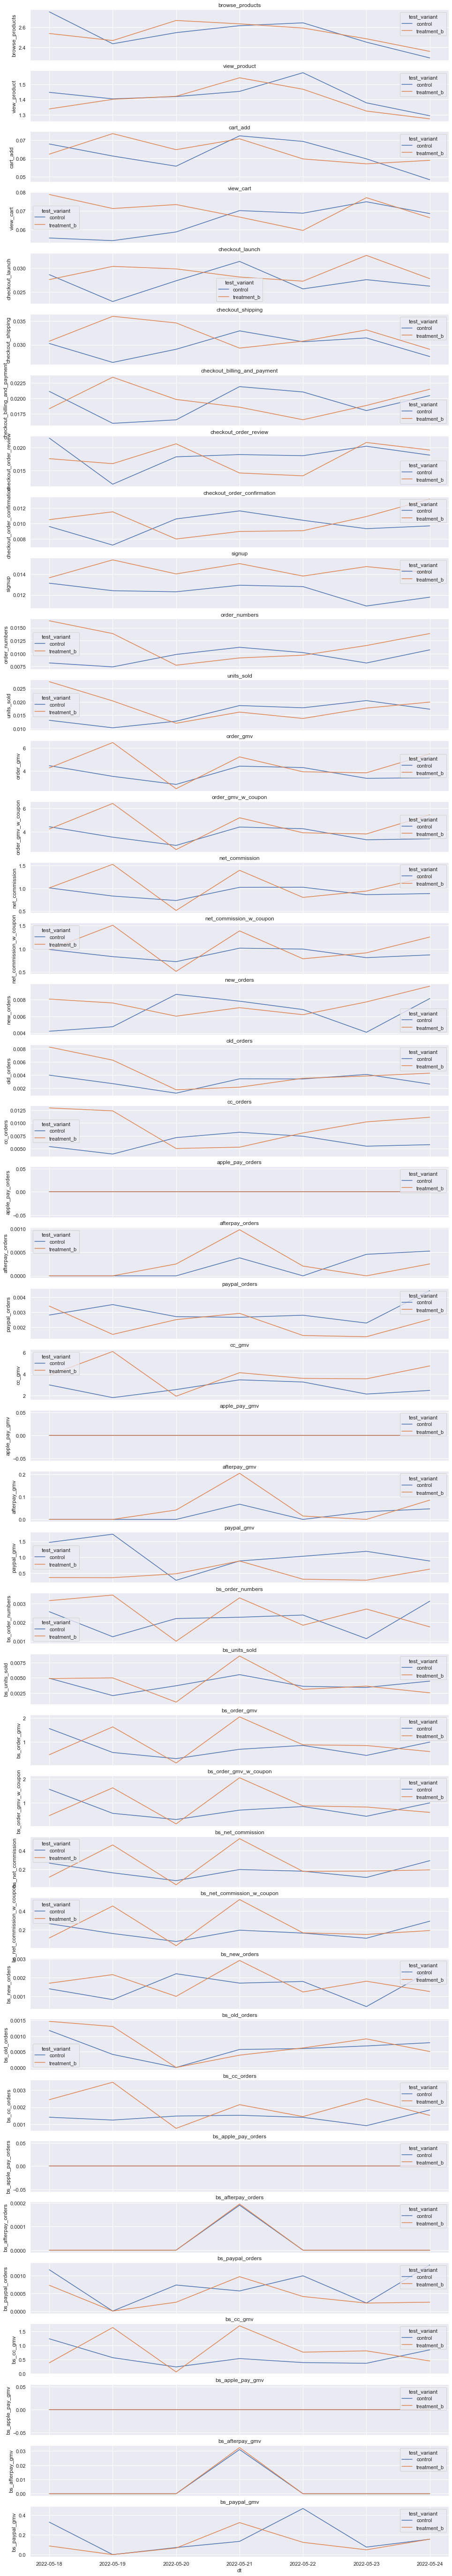

In [44]:
fig, axes = plt.subplots(len(metrics), 1, sharex=True, figsize=(16, 100))

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=dtd_metrics, x='dt', y=metric, hue='test_variant')
    axes[i].set_title(metric)
    # axes[i].set_ylim(ymin=0)

## Metrics Summary

In [45]:
q = """
select 
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv, 

		sum(bs_order_numbers) as bs_order_numbers,
		sum(bs_units_sold) as bs_units_sold,
		sum(bs_order_gmv) as bs_order_gmv,
		sum(bs_order_gmv_w_coupon) as bs_order_gmv_w_coupon,
		sum(bs_net_commission) as bs_net_commission,
		sum(bs_net_commission_w_coupon) as bs_net_commission_w_coupon,
		sum(bs_new_orders) as bs_new_orders,
		sum(bs_old_orders) as bs_old_orders,    
		sum(bs_cc_orders) as bs_cc_orders,
		sum(bs_apple_pay_orders) as bs_apple_pay_orders,
		sum(bs_afterpay_orders) as bs_afterpay_orders,
		sum(bs_paypal_orders) as bs_paypal_orders,
		sum(bs_cc_gmv) as bs_cc_gmv,
		sum(bs_apple_pay_gmv) as bs_apple_pay_gmv,
		sum(bs_afterpay_gmv) as bs_afterpay_gmv,
		sum(bs_paypal_gmv) as bs_paypal_gmv
from {tmp_final_table}
where order_gmv < 10000 or order_gmv is null
group by 1, 2
""".format(tmp_final_table=tmp_final_table)

df_all = pd.read_sql(q, conn)

df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,treatment_b,69,272,736,354,19,7,13,16,7,7,4,4,4.0,6.0,541.34,541.34,134.79,134.79,2.0,2.0,2.0,0.0,0.0,2.0,233.90,0.0,0.0,307.44,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
1,control,20,269,905,577,19,25,9,10,6,4,3,7,3.0,6.0,1200.00,1200.00,331.21,331.21,3.0,0.0,2.0,0.0,0.0,1.0,824.00,0.0,0.0,376.00,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
2,control,10,268,793,459,20,12,11,8,10,9,6,7,6.0,12.0,3068.94,3068.94,745.88,745.88,4.0,2.0,4.0,0.0,0.0,2.0,2232.94,0.0,0.0,836.00,2.0,7.0,285.95,285.95,89.980,89.980,2.0,0.0,1.0,0.0,0.0,1.0,107.95,0.0,0.0,178.00
3,control,36,258,654,379,13,6,6,7,5,5,2,2,2.0,3.0,321.00,321.00,86.09,86.09,1.0,1.0,1.0,0.0,1.0,0.0,158.00,0.0,163.0,0.00,1.0,1.0,163.00,163.00,30.070,30.070,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,163.0,0.00
4,treatment_b,62,231,818,360,27,16,7,9,6,8,2,3,2.0,3.0,109.87,109.87,24.87,24.87,1.0,1.0,2.0,0.0,0.0,0.0,109.87,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,control,97,305,934,517,29,30,17,14,15,14,9,9,10.0,20.0,2689.84,2689.84,594.66,594.66,7.0,3.0,7.0,0.0,0.0,3.0,2381.97,0.0,0.0,307.87,4.0,12.0,313.53,313.53,57.180,57.180,3.0,1.0,3.0,0.0,0.0,1.0,177.98,0.0,0.0,135.55
196,control,48,280,933,489,31,23,8,11,14,12,8,7,6.0,9.0,3241.54,3241.54,631.51,631.51,4.0,2.0,5.0,0.0,1.0,0.0,3155.54,0.0,86.0,0.00,1.0,1.0,915.00,915.00,121.185,121.185,0.0,1.0,1.0,0.0,0.0,0.0,915.00,0.0,0.0,0.00
197,treatment_b,6,275,753,468,28,29,13,23,14,4,3,4,3.0,3.0,354.17,354.17,94.33,94.33,0.0,3.0,3.0,0.0,0.0,0.0,354.17,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
198,treatment_b,21,279,766,446,23,19,9,7,5,5,2,2,2.0,2.0,244.00,244.00,49.37,49.37,2.0,0.0,1.0,0.0,0.0,1.0,135.00,0.0,0.0,109.00,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00


In [47]:
#  fillna metrics with 0
df_all[metrics].isna().sum().sum()
df_all[metrics] = df_all[metrics].fillna(0)

In [48]:
avg_col_list = ['avg_' + m for m in metrics]
df_all[avg_col_list] = df_all[metrics].div(df_all['visitors'], axis=0)
df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv,avg_browse_products,avg_view_product,avg_cart_add,avg_view_cart,avg_checkout_launch,avg_checkout_shipping,avg_checkout_billing_and_payment,avg_checkout_order_review,avg_checkout_order_confirmation,avg_signup,avg_order_numbers,avg_units_sold,avg_order_gmv,avg_order_gmv_w_coupon,avg_net_commission,avg_net_commission_w_coupon,avg_new_orders,avg_old_orders,avg_cc_orders,avg_apple_pay_orders,avg_afterpay_orders,avg_paypal_orders,avg_cc_gmv,avg_apple_pay_gmv,avg_afterpay_gmv,avg_paypal_gmv,avg_bs_order_numbers,avg_bs_units_sold,avg_bs_order_gmv,avg_bs_order_gmv_w_coupon,avg_bs_net_commission,avg_bs_net_commission_w_coupon,avg_bs_new_orders,avg_bs_old_orders,avg_bs_cc_orders,avg_bs_apple_pay_orders,avg_bs_afterpay_orders,avg_bs_paypal_orders,avg_bs_cc_gmv,avg_bs_apple_pay_gmv,avg_bs_afterpay_gmv,avg_bs_paypal_gmv
0,treatment_b,69,272,736,354,19,7,13,16,7,7,4,4,4.0,6.0,541.34,541.34,134.79,134.79,2.0,2.0,2.0,0.0,0.0,2.0,233.90,0.0,0.0,307.44,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,2.705882,1.301471,0.069853,0.025735,0.047794,0.058824,0.025735,0.025735,0.014706,0.014706,0.014706,0.022059,1.990221,1.990221,0.495551,0.495551,0.007353,0.007353,0.007353,0.0,0.000000,0.007353,0.859926,0.0,0.000000,1.130294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,control,20,269,905,577,19,25,9,10,6,4,3,7,3.0,6.0,1200.00,1200.00,331.21,331.21,3.0,0.0,2.0,0.0,0.0,1.0,824.00,0.0,0.0,376.00,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,3.364312,2.144981,0.070632,0.092937,0.033457,0.037175,0.022305,0.014870,0.011152,0.026022,0.011152,0.022305,4.460967,4.460967,1.231264,1.231264,0.011152,0.000000,0.007435,0.0,0.000000,0.003717,3.063197,0.0,0.000000,1.397770,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,control,10,268,793,459,20,12,11,8,10,9,6,7,6.0,12.0,3068.94,3068.94,745.88,745.88,4.0,2.0,4.0,0.0,0.0,2.0,2232.94,0.0,0.0,836.00,2.0,7.0,285.95,285.95,89.980,89.980,2.0,0.0,1.0,0.0,0.0,1.0,107.95,0.0,0.0,178.00,2.958955,1.712687,0.074627,0.044776,0.041045,0.029851,0.037313,0.033582,0.022388,0.026119,0.022388,0.044776,11.451269,11.451269,2.783134,2.783134,0.014925,0.007463,0.014925,0.0,0.000000,0.007463,8.331866,0.0,0.000000,3.119403,0.007463,0.026119,1.066978,1.066978,0.335746,0.335746,0.007463,0.000000,0.003731,0.0,0.000000,0.003731,0.402799,0.0,0.000000,0.664179
3,control,36,258,654,379,13,6,6,7,5,5,2,2,2.0,3.0,321.00,321.00,86.09,86.09,1.0,1.0,1.0,0.0,1.0,0.0,158.00,0.0,163.0,0.00,1.0,1.0,163.00,163.00,30.070,30.070,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,163.0,0.00,2.534884,1.468992,0.050388,0.023256,0.023256,0.027132,0.019380,0.019380,0.007752,0.007752,0.007752,0.011628,1.244186,1.244186,0.333682,0.333682,0.003876,0.003876,0.003876,0.0,0.003876,0.000000,0.612403,0.0,0.631783,0.000000,0.003876,0.003876,0.631783,0.631783,0.116550,0.116550,0.003876,0.000000,0.000000,0.0,0.003876,0.000000,0.000000,0.0,0.631783,0.000000
4,treatment_b,62,231,818,360,27,16,7,9,6,8,2,3,2.0,3.0,109.87,109.87,24.87,24.87,1.0,1.0,2.0,0.0,0.0,0.0,109.87,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,3.541126,1.558442,0.116883,0.069264,0.030303,0.038961,

In [52]:
calculate(df_all, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_browse_products,26542,78765.000000,2.9672,26965,80318.000000,2.9801,-0.01292,-0.43%,0.7925
1,avg_view_product,26542,43507.000000,1.6388,26965,45220.000000,1.6781,-0.03932,-2.34%,0.2845
2,avg_cart_add,26542,1994.000000,0.0755,26965,1990.000000,0.0738,0.00167,2.26%,0.6514
3,avg_view_cart,26542,2179.000000,0.0818,26965,2042.000000,0.0756,0.00616,8.15%,0.3220
4,avg_checkout_launch,26542,902.000000,0.0340,26965,858.000000,0.0317,0.00228,7.18%,0.2793
5,avg_checkout_shipping,26542,990.000000,0.0374,26965,943.000000,0.0349,0.00247,7.07%,0.3304
6,avg_checkout_billing_and_payment,26542,605.000000,0.0229,26965,611.000000,0.0226,0.00022,0.97%,0.9106
7,avg_checkout_order_review,26542,542.000000,0.0204,26965,572.000000,0.0212,-0.00080,-3.77%,0.6974
8,avg_checkout_order_confirmation,26542,318.000000,0.0120,26965,310.000000,0.0115,0.00057,4.95%,0.5796
9,avg_signup,26542,448.000000,0.0170,26965,391.000000,0.0145,0.00250,17.30%,0.0506


In [56]:
all_metrics_summery = calculate(df_all, avg_col_list, control, treatment)
all_metrics_summery.to_clipboard()

# Prepare data to session level to slice by Channel

In [71]:
pd.read_sql('drop table if exists {tmp_final_table}_by_channel'.format(tmp_final_table=tmp_final_table), conn)

q = """
create table {tmp_final_table}_by_channel AS
with xo as (

select dt, test_variant, visitor_id, medium, session_id, signin_status,

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3, 4, 5, 6

)
, mp as (

select 

		order_date, test_variant, visitor_id, 
		session_id,
	
	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv,

	-- bs mp metrics
		coalesce(count(distinct if(if_bs=1, order_id, null)),0) as bs_order_numbers,
    	count(if(if_bs=1, 1, null)) bs_units_sold,
	    sum(coalesce(if(if_bs=1, va.item_gmv, null),0)) as bs_order_gmv,
	    sum(coalesce(if(if_bs=1, va.item_gmv, null),0)+coalesce(if(if_bs=1, placed_order_item_coupon_amount, null), 0)) as bs_order_gmv_w_coupon,
	    sum(coalesce(if(if_bs=1, net_commission, null), 0)) as bs_net_commission,
	    sum(coalesce(if(if_bs=1, net_commission, null), 0)+coalesce(if(if_bs=1, placed_order_item_coupon_amount, null), 0)) as bs_net_commission_w_coupon,
    	coalesce(count(distinct if(if_bs=1, va.new_orders, null)),0) as bs_new_orders,
    	coalesce(count(distinct if(if_bs=1, va.old_orders, null)),0) as bs_old_orders,    
	    coalesce(count(distinct if(if_bs=1, cc_orders, null)), 0) as bs_cc_orders,
	    coalesce(count(distinct if(if_bs=1, apple_pay_orders, null)), 0) as bs_apple_pay_orders,
	    coalesce(count(distinct if(if_bs=1, afterpay_orders, null)), 0) as bs_afterpay_orders,
	    coalesce(count(distinct if(if_bs=1, paypal_orders, null)), 0) as bs_paypal_orders,
	    sum(coalesce(if(if_bs=1, cc_gmv, null), 0)) as bs_cc_gmv,
	    sum(coalesce(if(if_bs=1, apple_pay_gmv, null), 0)) as bs_apple_pay_gmv,
	    sum(coalesce(if(if_bs=1, afterpay_gmv, null), 0)) as bs_afterpay_gmv,
	    sum(coalesce(if(if_bs=1, paypal_gmv, null), 0)) as bs_paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3, 4
)

select 
		coalesce(order_date, xo.dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		coalesce(mp.session_id, xo.session_id) session_id,
		signin_status,
		medium,
		
		
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv,

		bs_order_numbers,
		bs_units_sold,
		bs_order_gmv,
		bs_order_gmv_w_coupon,
		bs_net_commission,
		bs_net_commission_w_coupon,
		bs_new_orders,
		bs_old_orders,    
		bs_cc_orders,
		bs_apple_pay_orders,
		bs_afterpay_orders,
		bs_paypal_orders,
		bs_cc_gmv,
		bs_apple_pay_gmv,
		bs_afterpay_gmv,
		bs_paypal_gmv
from xo
full join mp
on xo.session_id = mp.session_id

""".format(tmp_xo_metrics=tmp_xo_metrics,
            tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics
			)

# print(q)
pd.read_sql(q, conn)

,rows
0,80103


In [72]:
df_channel = pd.read_sql('select * from {tmp_final_table}_by_channel'.format(tmp_final_table=tmp_final_table), conn)
df_channel

,dt,test_variant,visitor_id,session_id,signin_status,medium,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,2022-05-23,control,0faf4a5c-c155-439e-9304-0ac92008a50e,7f2d6a1cf7e8a036ebd6065e809b0a14,PARTIAL_SIGNED_IN,PAID,1,0,0,2,1,3,2,1,1,0,1.0,1.0,759.21,719.21,136.66,96.66,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,759.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-05-19,control,b1bd01e5-36bd-494d-adbc-8e11dd4a3f33,69d8f713ec8e283e98e576f115af5af7,SIGNED_OUT,PAID,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-21,control,e870bc91-d15b-4cae-9f48-ed695cc82aad,a994d68ac9c31caebbdf1fb84b13f1c3,SIGNED_OUT,PAID,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-20,treatment_b,faf6aa51-35b7-4082-9e87-9a7f5b99e26e,f57c1ccef430aed1a5d1223bbf44fbff,SIGNED_OUT,DIRECT,3,2,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-21,treatment_b,2fcebaaf-8042-4c11-ab8a-1e6196c956d2,b29e34db0aec014ccff8f521ae03d9ea,SIGNED_OUT,PAID,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80098,2022-05-23,treatment_b,30d73bd5-5a8c-432a-9fa9-3bdb75a2ebd2,ba551df7755b668949914ddf0c75322c,SIGNED_OUT,PAID,1,2,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80099,2022-05-22,control,e787a7e2-4324-4041-afc8-1dcf2c6004f5,146a90c1bae83aa0bd1329e72ed6dceb,SIGNED_OUT,PAID,14,3,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80100,2022-05-22,treatment_b,67731a3f-8556-4d04-89c1-41408c4e47d0,50b3266acc47f5045e2fea88468f2a77,SIGNED_OUT,SOCIAL,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80101,2022-05-18,control,2d1f8a12-0d52-47f1-97ad-44ecf342ff7e,56f3319f9396564b1154c27d8b06002a,SIGNED_OUT,DIRECT,5,2,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Slice by Channel

In [75]:
# prepare data by slicing `signin_status during xo`
q = """
select 
		medium,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv,

		sum(bs_order_numbers) as bs_order_numbers,
		sum(bs_units_sold) as bs_units_sold,
		sum(bs_order_gmv) as bs_order_gmv,
		sum(bs_order_gmv_w_coupon) as bs_order_gmv_w_coupon,
		sum(bs_net_commission) as bs_net_commission,
		sum(bs_net_commission_w_coupon) as bs_net_commission_w_coupon,
		sum(bs_new_orders) as bs_new_orders,
		sum(bs_old_orders) as bs_old_orders,    
		sum(bs_cc_orders) as bs_cc_orders,
		sum(bs_apple_pay_orders) as bs_apple_pay_orders,
		sum(bs_afterpay_orders) as bs_afterpay_orders,
		sum(bs_paypal_orders) as bs_paypal_orders,
		sum(bs_cc_gmv) as bs_cc_gmv,
		sum(bs_apple_pay_gmv) as bs_apple_pay_gmv,
		sum(bs_afterpay_gmv) as bs_afterpay_gmv,
		sum(bs_paypal_gmv) as bs_paypal_gmv
from {tmp_final_table}_by_channel
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
""".format(tmp_final_table=tmp_final_table)

df_channel = pd.read_sql(q, conn)

df_channel

,medium,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,SEARCH,control,27,57,227,165,2,2,1,1,1,1,1,0,1.0,12.0,84.00,84.00,0.00,0.00,0.0,1.0,1.0,0.0,0.0,0.0,84.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DIRECT,control,8,45,241,141,7,12,2,1,1,4,3,0,1.0,2.0,347.14,347.14,62.48,62.48,0.0,1.0,1.0,0.0,0.0,0.0,347.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SOCIAL,treatment_b,26,2,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SEARCH,control,50,63,186,67,13,3,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOUZZ_OWN,treatment_b,27,2,1,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,EMAIL,control,35,11,61,70,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1224,PAID,control,28,185,414,227,11,24,10,14,8,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1225,DIRECT,treatment_b,65,40,108,55,2,4,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1226,EMAIL,control,22,11,23,14,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
def metricSummary(df):
    df[metrics] = df[metrics].fillna(0)
    df[avg_col_list] = df[metrics].div(df['visitors'], axis=0)
    # metricSum = calculate(df, avg_col_list, control, treatment).reset_index()\
    # .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)
    # return metricSum
    return calculate(df, avg_col_list, control, treatment)#.reset_index()#\
    #.drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)


In [78]:
df_channel.groupby('medium').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', 10)
df_channel.groupby('medium').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

# Browse Ranking

In [80]:
br = pd.read_sql('select * from {tmp_browse_ranking} where if_bs = 1'.format(tmp_browse_ranking=tmp_browse_ranking), conn)
br

,if_bs,test_variant,search,page_key,module_key,object_id,pos_index,pos_id,transition_clicked,trackme_clicked,any_click,session_id,visitor_id,comp_id,price,dt
0,1,control,,16b3c7a4-f540-4694-95c2-059fb6bf565e,fe926cdf9bac1891c46cdd66c4d21670,115295225,35,None,False,False,False,17e5d922ce8a566d6cd9956871e39c91,97ad57dc-c518-4d97-957c-b0c128942d41,None,0.0,2022-05-18
1,1,control,,16b3c7a4-f540-4694-95c2-059fb6bf565e,fe926cdf9bac1891c46cdd66c4d21670,141856919,21,None,False,False,False,17e5d922ce8a566d6cd9956871e39c91,97ad57dc-c518-4d97-957c-b0c128942d41,None,0.0,2022-05-18
2,1,treatment_b,,435e4a1e-dde7-4011-91a2-62e9ad4f9d91,bad67848c43ccfe33b0b0ea959fce986,39907387,21,None,False,False,False,5bfb452db493f977b0685d95ee386fdd,86bf326c-ac40-43ab-b219-c7bd90801b28,None,0.0,2022-05-23
3,1,control,,a5637779-5303-4d02-b000-0fc82a051337,c51448365ee609ed95462c54566c1f5d,51824740,0,None,False,False,False,95669408e1c44f3a01c26270c184197b,844527f4-ad11-4994-b43a-c84cc41989a6,None,0.0,2022-05-21
4,1,control,stools,f11ffb6c-b5ef-47c6-bd1b-0d3800df029c,2905bbb98971eacd122319d191278a56,117934088,30,None,False,False,False,5ce0f7ae768aaf9ae0d9f02e36a2c637,7cec567a-9873-46b9-9ff8-4bc7534a2e37,None,0.0,2022-05-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475793,1,control,,604837a4-030e-46dd-a5a3-56e632f005a6,597e63a9db2aa2e62f3fd6cfb8193a00,169853793,33,None,False,False,False,cc16e7a6347216aadbc75e89f4b2124d,d25a6250-ee17-4559-824c-e3af84371bea,None,0.0,2022-05-19
475794,1,control,,604837a4-030e-46dd-a5a3-56e632f005a6,597e63a9db2aa2e62f3fd6cfb8193a00,137581438,20,None,False,False,False,cc16e7a6347216aadbc75e89f4b2124d,d25a6250-ee17-4559-824c-e3af84371bea,None,0.0,2022-05-19
475795,1,treatment_b,,5420652d-354f-492d-b111-567372679528,2885642e08d3bfc6a0800a26ad909689,15794703,20,None,False,False,False,2676b583dbb94a58e91971ca97e25032,d0efe2e9-e243-4803-86ec-716c7db49b5e,None,0.0,2022-05-22
475796,1,control,,4c8b9b28-8505-4d98-926c-72b651e6bf2f,a779e4fbf68290f11df0fc967e7c06c6,90271001,27,None,False,False,False,1acb47eb3c9bacb65acf73a44a275c20,7a45ca82-0894-4fed-b23c-0bfe00af0c76,None,0.0,2022-05-20


<Figure size 1152x288 with 0 Axes>

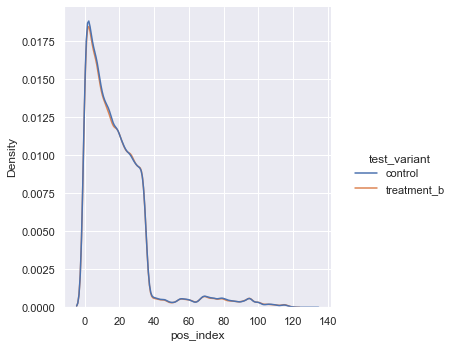

In [81]:
# bs browse ranking vs non-bs
plt.figure(figsize=(16,4)) 
sns.displot(data=br, x='pos_index', hue='test_variant', kind='kde')

In [97]:
non_bs_pos = pd.read_sql('select test_variant, histogram(pos_index) from {tmp_browse_ranking} where if_bs = 0 group by 1'.format(tmp_browse_ranking=tmp_browse_ranking), conn)
non_bs_pos

,test_variant,_col1
0,control,"{'0': 40310, '1': 41395, '2': 43371, '3': 42629, '4': 43109, '5': 44165, '6': 43168, '7': 43629, '8': 43993, '9': 44305, '10': 44834, '11': 44597, '12': 44802, '13': 44822, '14': 44651, '15': 44836, '16': 45271, '17': 45243, '18': 45273, '19': 44686, '20': 45409, '21': 45441, '22': 45282, '23': 45525, '24': 45563, '25': 45668, '26': 45161, '27': 45621, '28': 45637, '29': 45604, '30': 45509, '31': 45686, '32': 45686, '33': 45088, '34': 45591, '35': 45652, '36': 2162, '37': 2068, '38': 1914, '39': 1920, '40': 2022, '41': 1940, '42': 2039, '43': 1977, '44': 2101, '45': 2031, '46': 1966, '47': 2033, '48': 2149, '49': 2089, '50': 2189, '51': 2042, '52': 2198, '53': 2118, '54': 2000, '55': 1945, '56': 1987, '57': 2091, '58': 1932, '59': 2057, '60': 1997, '61': 1987, '62': 2063, '63': 2104, '64': 2121, '65': 2112, '66': 2021, '67': 1954, '68': 1859, '69': 1807, '70': 1873, '71': 1953, '72': 1826, '73': 1914, '74': 1820, '75': 1896, '76': 1928, '77': 1917, '78': 1914, '79': 1749, '80': 1904, '81': 1949, '82': 1838, '83': 1999, '84': 1953, '85': 1856, '86': 2051, '87': 1876, '88': 1961, '89': 1994, '90': 1993, '91': 1881, '92': 1880, '93': 1954, '94': 1813, '95': 1296, '96': 1660, '97': 1574, '98': 1580, '99': 1403, ...}"
1,treatment_b,"{'0': 39164, '1': 40368, '2': 42349, '3': 41463, '4': 42045, '5': 43097, '6': 41980, '7': 42554, '8': 42941, '9': 43298, '10': 43724, '11': 43353, '12': 43474, '13': 43800, '14': 43505, '15': 43786, '16': 44138, '17': 44008, '18': 44009, '19': 43445, '20': 44059, '21': 44201, '22': 44069, '23': 44205, '24': 44343, '25': 44569, '26': 43739, '27': 44358, '28': 44235, '29': 44446, '30': 44338, '31': 44492, '32': 44349, '33': 43803, '34': 44362, '35': 44528, '36': 2181, '37': 2097, '38': 2005, '39': 1987, '40': 2063, '41': 1988, '42': 2062, '43': 2054, '44': 2122, '45': 2063, '46': 1999, '47': 2095, '48': 2167, '49': 2142, '50': 2209, '51': 2093, '52': 2181, '53': 2135, '54': 2030, '55': 1982, '56': 2016, '57': 2100, '58': 1992, '59': 2074, '60': 2062, '61': 2014, '62': 2113, '63': 2125, '64': 2162, '65': 2138, '66': 2050, '67': 2016, '68': 1907, '69': 1853, '70': 1885, '71': 1995, '72': 1915, '73': 1962, '74': 1825, '75': 1906, '76': 1992, '77': 1938, '78': 1953, '79': 1791, '80': 1953, '81': 1985, '82': 1913, '83': 2039, '84': 1979, '85': 1885, '86': 2066, '87': 1926, '88': 2006, '89': 2004, '90': 1904, '91': 1844, '92': 1821, '93': 1899, '94': 1769, '95': 1340, '96': 1653, '97': 1588, '98': 1613, '99': 1507, ...}"


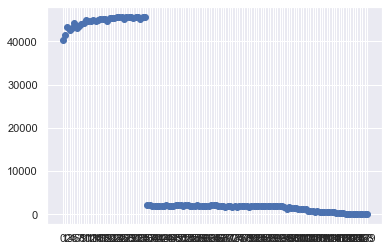

In [104]:
non_bs_pos_ctrl = non_bs_pos.loc[non_bs_pos['test_variant']=='control', '_col1'][0]
plt.scatter(non_bs_pos_ctrl.keys(), non_bs_pos_ctrl.values())

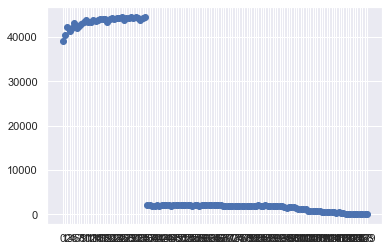

In [107]:
non_bs_pos_trt = non_bs_pos.loc[non_bs_pos['test_variant']=='treatment_b', '_col1'][1]
plt.scatter(non_bs_pos_trt.keys(), non_bs_pos_trt.values())

In [122]:
# browse to click rate

q = """
with dv as (
select 
		dt, 
		visitor_id, 
		test_variant,
		
		if_bs, 
		count(object_id) imps,
		count(distinct object_id) unique_product_imps,
		count(if(any_click = true, object_id, null)) clicks,
		count(distinct if(any_click = true, object_id, null)) unique_product_clicks
from wandajuan.browse_ranking_mp_mweb_best_seller_label_v2
group by 1, 2, 3, 4
)
select 
		test_variant, 
		cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(imps) imps,
		sum(unique_product_imps) unique_product_imps,
		sum(clicks) clicks,
		sum(unique_product_clicks) unique_product_clicks,

		sum(if(if_bs=1, imps, 0)) bs_imps,
		sum(if(if_bs=1, unique_product_imps, 0)) bs_unique_product_imps,
		sum(if(if_bs=1, clicks, 0)) bs_clicks,
		sum(if(if_bs=1, unique_product_clicks, 0)) bs_unique_product_clicks,

		sum(if(if_bs=0, imps, 0)) nonbs_imps,
		sum(if(if_bs=0, unique_product_imps, 0)) nonbs_unique_product_imps,
		sum(if(if_bs=0, clicks, 0)) nonbs_clicks,
		sum(if(if_bs=0, unique_product_clicks, 0)) nonbs_unique_product_clicks

from dv
group by 1, 2
"""

df_browse_click = pd.read_sql(q, conn)
df_browse_click




,test_variant,bucket,visitors,imps,unique_product_imps,clicks,unique_product_clicks,bs_imps,bs_unique_product_imps,bs_clicks,bs_unique_product_clicks,nonbs_imps,nonbs_unique_product_imps,nonbs_clicks,nonbs_unique_product_clicks
0,treatment_b,47,118,17371,12530,0,0,2219,1453,0,0,15152,11077,0,0
1,control,74,115,22783,17881,0,0,2325,1628,0,0,20458,16253,0,0
2,treatment_b,42,130,21768,15094,0,0,3080,1941,0,0,18688,13153,0,0
3,control,60,116,20842,14811,0,0,2357,1548,0,0,18485,13263,0,0
4,treatment_b,93,107,17852,13298,0,0,2257,1565,0,0,15595,11733,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,treatment_b,71,135,24243,17365,0,0,2933,1996,0,0,21310,15369,0,0
196,treatment_b,2,117,16537,13054,0,0,2196,1598,0,0,14341,11456,0,0
197,treatment_b,75,131,23447,17243,0,0,2801,1891,0,0,20646,15352,0,0
198,control,80,117,22644,16611,0,0,2942,1830,0,0,19702,14781,0,0


In [123]:
bc_metrics = df_browse_click.columns[3:]
df_browse_click[bc_metrics].isna().sum().sum()
# df_browse_click[bc_metrics] = df_browse_click[bc_metrics].fillna(0)

0

In [124]:
avg_col_list = ['avg_' + m for m in bc_metrics]
df_browse_click[avg_col_list] = df_browse_click[bc_metrics].div(df_browse_click['visitors'], axis=0)
df_browse_click

,test_variant,bucket,visitors,imps,unique_product_imps,clicks,unique_product_clicks,bs_imps,bs_unique_product_imps,bs_clicks,bs_unique_product_clicks,nonbs_imps,nonbs_unique_product_imps,nonbs_clicks,nonbs_unique_product_clicks,avg_imps,avg_unique_product_imps,avg_clicks,avg_unique_product_clicks,avg_bs_imps,avg_bs_unique_product_imps,avg_bs_clicks,avg_bs_unique_product_clicks,avg_nonbs_imps,avg_nonbs_unique_product_imps,avg_nonbs_clicks,avg_nonbs_unique_product_clicks
0,treatment_b,47,118,17371,12530,0,0,2219,1453,0,0,15152,11077,0,0,147.211864,106.186441,0.0,0.0,18.805085,12.313559,0.0,0.0,128.406780,93.872881,0.0,0.0
1,control,74,115,22783,17881,0,0,2325,1628,0,0,20458,16253,0,0,198.113043,155.486957,0.0,0.0,20.217391,14.156522,0.0,0.0,177.895652,141.330435,0.0,0.0
2,treatment_b,42,130,21768,15094,0,0,3080,1941,0,0,18688,13153,0,0,167.446154,116.107692,0.0,0.0,23.692308,14.930769,0.0,0.0,143.753846,101.176923,0.0,0.0
3,control,60,116,20842,14811,0,0,2357,1548,0,0,18485,13263,0,0,179.672414,127.681034,0.0,0.0,20.318966,13.344828,0.0,0.0,159.353448,114.336207,0.0,0.0
4,treatment_b,93,107,17852,13298,0,0,2257,1565,0,0,15595,11733,0,0,166.841121,124.280374,0.0,0.0,21.093458,14.626168,0.0,0.0,145.747664,109.654206,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,treatment_b,71,135,24243,17365,0,0,2933,1996,0,0,21310,15369,0,0,179.577778,128.629630,0.0,0.0,21.725926,14.785185,0.0,0.0,157.851852,113.844444,0.0,0.0
196,treatment_b,2,117,16537,13054,0,0,2196,1598,0,0,14341,11456,0,0,141.341880,111.572650,0.0,0.0,18.769231,13.658120,0.0,0.0,122.572650,97.914530,0.0,0.0
197,treatment_b,75,131,23447,17243,0,0,2801,1891,0,0,20646,15352,0,0,178.984733,131.625954,0.0,0.0,21.381679,14.435115,0.0,0.0,157.603053,117.190840,0.0,0.0
198,control,80,117,22644,16611,0,0,2942,1830,0,0,19702,14781,0,0,193.538462,141.974359,0.0,0.0,25.145299,15.641026,0.0,0.0,168.393162,126.333333,0.0,0.0


In [126]:
calculate(df_browse_click, avg_col_list, control, treatment).to_clipboard()
calculate(df_browse_click, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_imps,11930,1942342.000000,162.7136,12030,1985167.000000,165.1993,-2.48568,-1.50%,0.4494
1,avg_unique_product_imps,11930,1420341.000000,118.9833,12030,1447937.000000,120.4643,-1.48101,-1.23%,0.5463
2,avg_clicks,11930,64.000000,0.0054,12030,34.000000,0.0028,0.00264,94.52%,0.1735
3,avg_unique_product_clicks,11930,62.000000,0.0053,12030,32.000000,0.0026,0.00264,100.71%,0.1595
4,avg_bs_imps,11930,236609.000000,19.8207,12030,239189.000000,19.9159,-0.09523,-0.48%,0.7839
5,avg_bs_unique_product_imps,11930,161280.000000,13.5150,12030,162210.000000,13.4971,0.01788,0.13%,0.9298
6,avg_bs_clicks,11930,10.000000,0.0008,12030,5.000000,0.0004,0.00040,95.26%,0.3430
7,avg_bs_unique_product_clicks,11930,10.000000,0.0008,12030,4.000000,0.0003,0.00048,144.17%,0.2003
8,avg_nonbs_imps,11930,1705733.000000,142.8929,12030,1745978.000000,145.2834,-2.39045,-1.65%,0.4388
9,avg_nonbs_unique_product_imps,11930,1259061.000000,105.4683,12030,1285727.000000,106.9672,-1.49889,-1.40%,0.5240


# Visits to Best Seller topic pages

In [118]:
q = """
select pv.dt, test_variant, count(distinct vb.visitor_id) visitors, count(1) page_views, sum(active_time_on_page) active_time_on_page, sum(total_time_on_page) total_time_on_page 
from {tmp_visitor_base} vb
join (
		select dt, visitor_id, topic, url, active_time_on_page, total_time_on_page
		from l2.page_views_daily
		where dt >= '2022-05-14'
		and url like '%products%/label--best-seller'
) pv
on vb.visitor_id = pv.visitor_id and pv.dt >= vb.dt
group by 1, 2
order by 1, 2
""".format(tmp_visitor_base=tmp_visitor_base)

df_topics = pd.read_sql(q, conn)
df_topics

,dt,test_variant,visitors,page_views,active_time_on_page,total_time_on_page
0,2022-05-18,control,1,1,0,0
1,2022-05-18,treatment_b,1,1,0,0
2,2022-05-19,control,1,1,98,511
3,2022-05-19,treatment_b,1,1,0,0
4,2022-05-20,control,3,3,0,0
...,...,...,...,...,...,...
6,2022-05-22,control,4,4,2,119
7,2022-05-22,treatment_b,3,3,39,112
8,2022-05-23,control,2,2,49,210
9,2022-05-23,treatment_b,2,2,0,0
